# Integration of cloud-equations in moist atmosphere

In this notebook we will demonstrate integrating the full cloud-model equations with a microphysics scheme that accounts for the creation of cloud-droplets and rain-formation. We will use precipitating shallow convection case, RICO ([van Zanten 2011](https://github.com/leifdenby/moistconvection/blob/master/cases/RICO/papers/vanZanten2011.pdf)) to define the ambient stratification.

In [1]:
import numpy as np   
import matplotlib.pyplot as plt
import pyclouds

%matplotlib inline

In [2]:
pyclouds.__version__

'v0.2.0+6.g670f59d.dirty'

In [3]:
from pyclouds.models import parcel as parcel_models, microphysics as microphysics_models
from pyclouds.reference.atmos import stratification_profiles
from pyclouds.reference import constants as reference_constants
from pyclouds import Var
from pyclouds.plot import parcel as parcel_plot

# Ambient state

The RICO profile is characterised by a well-mixed boundary-layer up to cloud-base at ~600m and an
inversion aloft (above ~4km) stopping the shallow clouds from going deep

In [4]:
ambient_stratification = stratification_profiles.RICO()

Text(0, 0.5, 'heigth [m]')

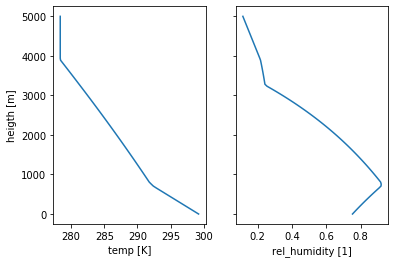

In [5]:
plot_vars = ["temp", "rel_humidity", ]
units = dict(temp="K", rel_humidity="1")
fig, axes = plt.subplots(ncols=len(plot_vars), figsize=((3.0*len(plot_vars), 4)), sharey=True,)
z_ = np.linspace(0., 5.0e3, 100)

for ax, v in zip(axes, plot_vars):
    vals = getattr(ambient_stratification, v)(z_)
    ax.plot(vals, z_)

[ax.set_xlabel(f"{v} [{units[v]}]") for (ax, v) in zip(axes, plot_vars)]    
axes[0].set_ylabel("heigth [m]")

# Model integration

Define heights at which we want the parcel values and the initial condition. We start with a rising parcel which is slightly moister than the environment and has already started rising (`w > 0.0`)


In [6]:
z0 = 500.
z_points = np.linspace(z0, 10e3, 5000)

w0 = 2.0
r0 = 400.
T0 = ambient_stratification.temp(z0)
p0 = ambient_stratification.p(z0)
qv0 = ambient_stratification.q_t(z0) + 0.001

# r, w, T, q_v, q_r, q_l, q_i
initial_condition = Var.make_state(r=r0, w=w0, T=T0, q_v=qv0, q_l=0.0, q_i=0.0, p=p0)

As an experiment here we will see what happens when we turn reformation of inside the microphysics routines. Rainout should cause the parcel to become lighter and so rise further

In [7]:
beta = 0.2

constraint = 'isobaric'

# reference solution with rain-out
microphysics = microphysics_models.FiniteCondensationTimeMicrophysics(
    model_constraint=constraint,
)
cloud_model = parcel_models.FullThermodynamicsCloudEquations(
    environment=ambient_stratification, gamma=1.0, C_D=0.1, beta=beta, 
    microphysics=microphysics
)
profile1 = cloud_model.integrate(initial_condition, z_points)

# solution where rain-formation has been disabled in microphysics
microphysics = microphysics_models.FiniteCondensationTimeMicrophysics(
    model_constraint=constraint, disable_rain=True
)
cloud_model = parcel_models.FullThermodynamicsCloudEquations(
    environment=ambient_stratification, gamma=1.0, C_D=0.1, beta=beta, 
    microphysics=microphysics
)
profile2 = cloud_model.integrate(initial_condition, z_points)


/home/earlcd/pytools/pyclouds/models/microphysics.py:281: UserWarning: EoS calculation stored within microphysics, should really use something defined externally
  "EoS calculation stored within microphysics, should really use something defined externally"
/home/earlcd/pytools/pyclouds/models/microphysics.py:433: RuntimeWarning: divide by zero encountered in double_scalars
  lambda_r = (pi * (qg * rho_l) / (qr * rho_g) * N0r) ** (1.0 / 4.0)
/home/earlcd/pytools/pyclouds/models/parcel.py:573: RuntimeWarning: divide by zero encountered in double_scalars
  l = (8.0 * rho_l * pi * N0 / (q_r * rho_c)) ** 0.25
/home/earlcd/pytools/pyclouds/models/microphysics.py:470: RuntimeWarning: invalid value encountered in double_scalars
  r_c = (ql * rho / (4.0 / 3.0 * pi * self.N0 * rho_l)) ** (1.0 / 3.0)
/home/earlcd/pytools/pyclouds/models/microphysics.py:433: RuntimeWarning: invalid value encountered in double_scalars
  lambda_r = (pi * (qg * rho_l) / (qr * rho_g) * N0r) ** (1.0 / 4.0)
/home/earlcd

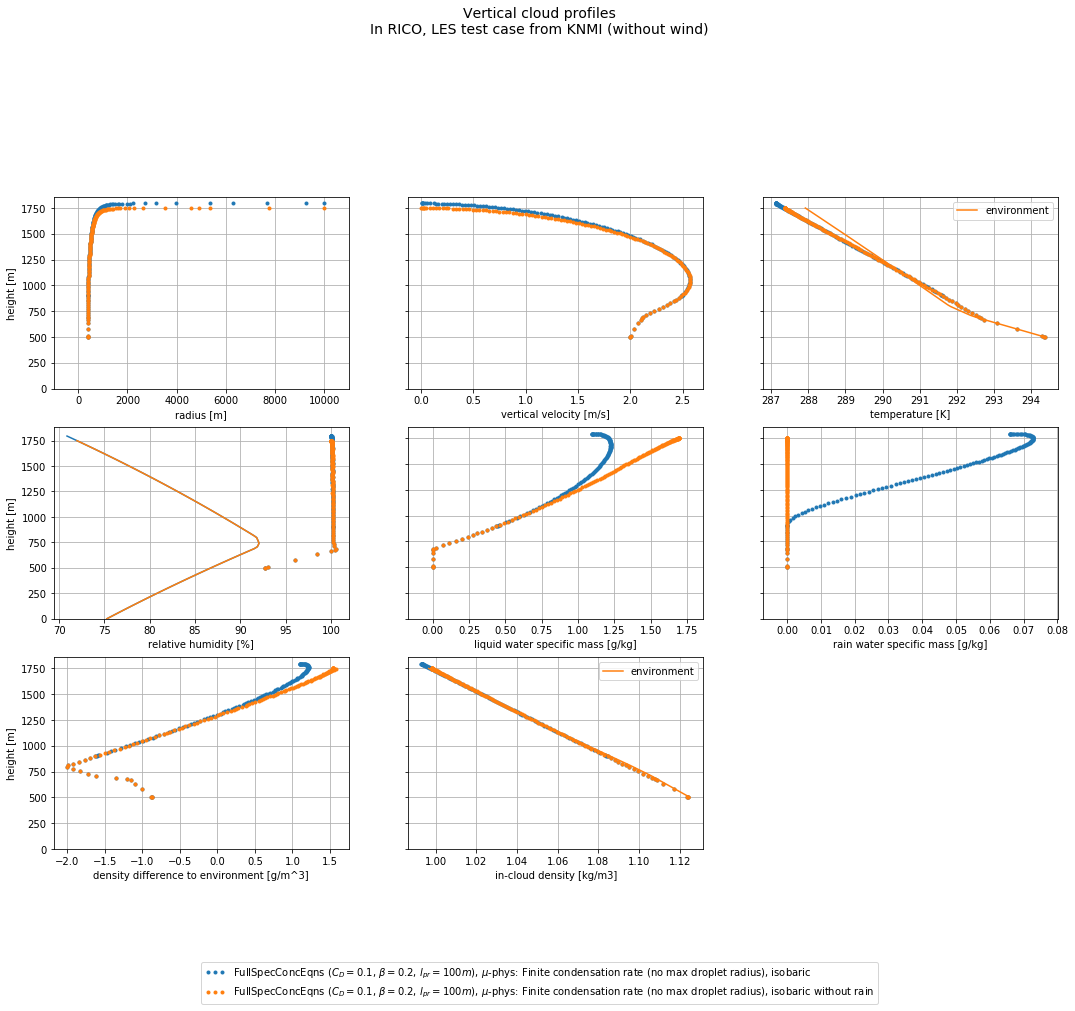

In [8]:
fig = parcel_plot.plot_profiles([profile1, profile2], ['r', 'w', 'T', "RH", 'q_l', "q_r", "d_rho", "rho_c"])
#fig.savefig('/home/zmaw/m300464/Desktop/cloudmodel_profile.pdf')

By removing the ability for the cloud to rain out the cloud-droplets build up inside the parcel causing it to be heavier and reached a neutral buoyancy at a lower altitude

# Effect of entrainment rate

We now turn to changing the entrainment rate in the cloud-model to investigate its effect

In [9]:
profiles = []

microphysics = microphysics_models.FiniteCondensationTimeMicrophysics(model_constraint='isobaric')

beta = 0.2
cloud_model = parcel_models.FullThermodynamicsCloudEquations(
    environment=ambient_stratification, gamma=1.0, C_D=0.1, beta=beta, microphysics=microphysics
)
p = cloud_model.integrate(initial_condition, z_points)
profiles.append(p)

beta = 0.1
cloud_model = parcel_models.FullThermodynamicsCloudEquations(
    environment=ambient_stratification, gamma=1.0, C_D=0.1, beta=beta, microphysics=microphysics
)
p = cloud_model.integrate(initial_condition, z_points)
profiles.append(p)

/home/earlcd/pytools/pyclouds/reference/parameterisations.py:170: RuntimeWarning: invalid value encountered in double_scalars
  return 1.72e-5 * (393.0 / (T + 120.0)) * (T / 273.0) ** (3.0 / 2.0)


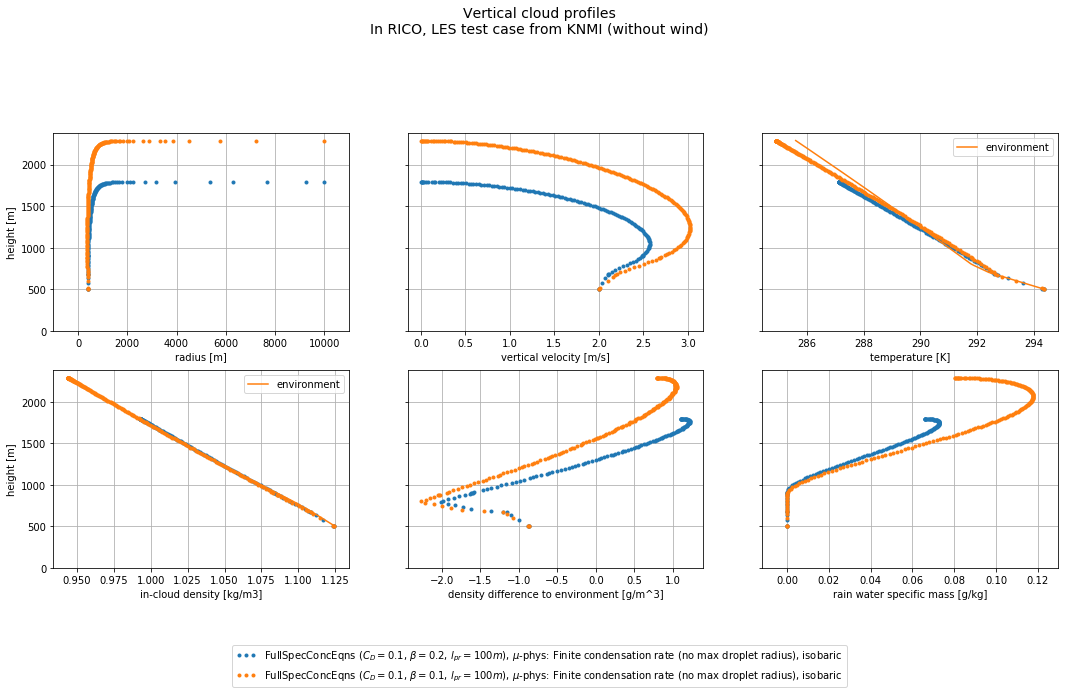

In [10]:
fig = pyclouds.plot.parcel.plot_profiles(profiles, ['r', 'w', 'T', "rho_c", "d_rho", "q_r"])
#fig.savefig('/home/zmaw/m300464/Desktop/cloudmodel_profile.pdf')

With higher entrainment rate the parcel is diluted more quickly and so looses its buoyancy and momentum more quickly leading to a lower termination heigth